# Gaussian Process and Machine Learning

In [1]:
import Base: rand

using Distributions
using LinearAlgebra
using Plots
using Printf

## Define Kernels and Gaussian Process

In [2]:
abstract type Kernel end
ElementOrVector{T} = Union{T, Vector{T}}
VectorOrMatrix{T} = Union{Vector{T}, Array{T, 2}}


# Gaussian kernel / radial basis function
struct GaussianKernel{T <: Real} <: Kernel
    theta1::T
    theta2::T
    function GaussianKernel(theta1::T, theta2::T) where {T <: Real}
        theta2 == 0 ? throw(DomainError(theta2, "theta2 must not be zero")) : new{T}(theta1, theta2)
    end
end

function ker(k::GaussianKernel, x1::ElementOrVector{T}, x2::ElementOrVector{T}) where {T <: Real}
    Base.length(x1) == Base.length(x2) || throw(DimensionMismatch("size of x1 not equal to size of x2"))
    k.theta1 * exp(- sum(abs.(x1 - x2).^2) / k.theta2)
end


# Gaussian Process
struct GaussianProcess{K <: Kernel}
    kernel::K
    eta::Float64 # regularization parameter
    GaussianProcess(kernel::K) where {K <: Kernel} = new{K}(kernel, 1e-6)
end


# covariance matrix
function cov(gp::GaussianProcess{K}, xs::VectorOrMatrix{T}) where {K <: Kernel, T <: Real}
    n = size(xs, 1)
    c = zeros(n, n)
    for i in 1:n
        for j in 1:n
            c[i, j] = ker(gp.kernel, xs[i, :], xs[j, :])
        end
    end
    # regularlize
    c += gp.eta .* Matrix{Float64}(I, n, n) 
    c
end

# sampling function
function rand(gp::GaussianProcess{K}, xs::VectorOrMatrix{T}) where {K <: Kernel, T <: Real}
    l = size(xs, 1)
    k = cov(gp, xs)
    Base.rand(MvNormal(zeros(l), k))
end

function rand(gp::GaussianProcess{K}, xs::VectorOrMatrix{T}, n::Int) where {K <: Kernel, T <: Real}
    l = size(xs, 1)
    k = cov(gp, xs)
    Base.rand(MvNormal(zeros(l), k), n)
end

rand (generic function with 168 methods)

## Sampling from 1D Gaussian Process

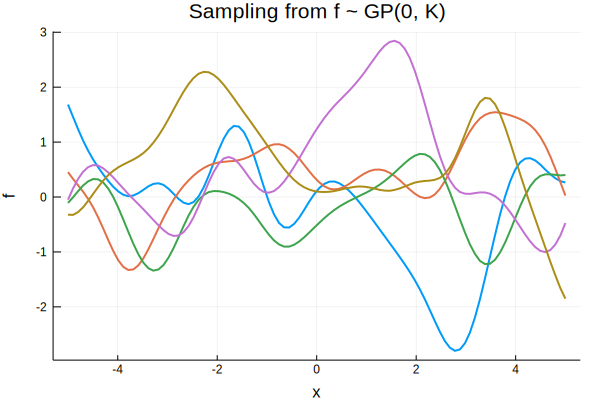

In [3]:
xs = collect(range(-5, stop = 5, length = 100))

gp = GaussianProcess(GaussianKernel(1, 1))
Plots.plot(xs, rand(gp, xs, 5), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "Sampling from f ~ GP(0, K)")

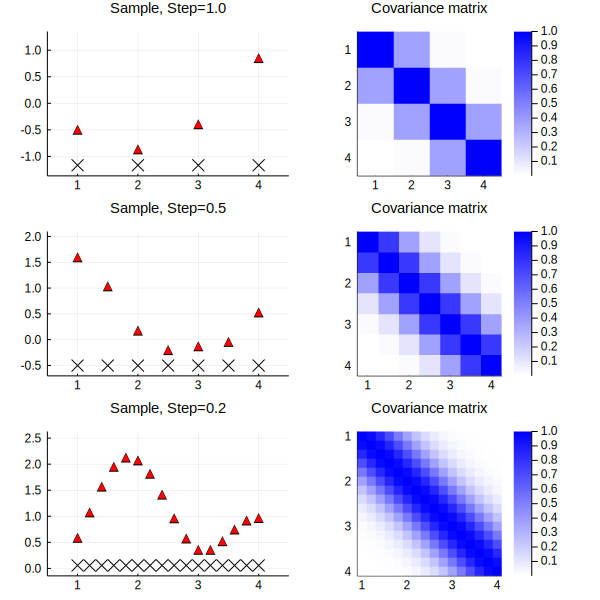

In [4]:
xx = [1:4, 1:0.5:4, 1:0.2:4]
yy = [1, 0.5, 0.2]

plts = []
for (x, y) in zip(xx, yy)
    x1 = collect(x)
    n = Base.length(x)
    sample = rand(gp, x1)
    sample_min = minimum(sample)
    sample_plot = scatter(x, sample, label = "",
            markershape = :utriangle, markercolor = :red,
            title = @sprintf("Sample, Step=%.1f", y), titlefontsize = 10)
    scatter!(x, fill(sample_min - 0.3, n),
        xlims = (0.5, 4.5),
        ylims = (sample_min - 0.5, maximum(sample) + 0.5),
        markershape = :x, markerstrokewidth = 2,
        label = "")
    push!(plts, sample_plot)
    push!(plts, heatmap(x1, x1, cov(gp, x1), 
            title = "Covariance matrix", titlefontsize = 10,
            aspect_ratio = :equal, yflip = true, color = cgrad([:white, :blue])))
end

Plots.plot(plts..., layout = (3, 2), size = [600, 600])

In [5]:
x1, x2 = 0:0.05:1, 0:0.05:1
n1, n2 = Base.length(x1), Base.length(x2)
n = n1 * n2
pt = permutedims(hcat([[i, j] for i in x1, j in x2]...))

441×2 Array{Float64,2}:
 0.0   0.0
 0.05  0.0
 0.1   0.0
 0.15  0.0
 0.2   0.0
 0.25  0.0
 0.3   0.0
 0.35  0.0
 0.4   0.0
 0.45  0.0
 0.5   0.0
 0.55  0.0
 0.6   0.0
 ⋮        
 0.45  1.0
 0.5   1.0
 0.55  1.0
 0.6   1.0
 0.65  1.0
 0.7   1.0
 0.75  1.0
 0.8   1.0
 0.85  1.0
 0.9   1.0
 0.95  1.0
 1.0   1.0

## Sampling from 2D Gaussian Process

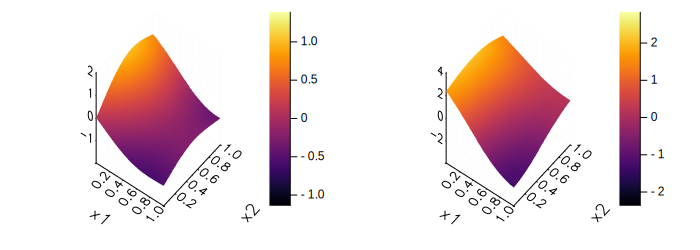

In [6]:
sample = rand(gp, pt, 2)

plts = []

for i in 1:2
    z = reshape(sample[:, i], n1, n2)
    push!(plts,
        surface(x1, x2, z, alpha = 0.8, camera = (40, 60),
        linewidth = 2,
        framestyle = :grid,
        xlabel = "x1", ylabel = "x2", zlabel = "f"))
end

Plots.plot(plts..., layout = (1, 2), size = [700, 250])

## Kernel Types

In [7]:
# Linear kernel
struct LinearKernel <: Kernel end

function ker(k::LinearKernel, x1::ElementOrVector{T}, x2::ElementOrVector{T}) where {T <: Real}
    Base.length(x1) == Base.length(x2) || throw(DimensionMismatch("size of x1 not equal to size of x2"))
    1 + dot(x1, x2)
end


# Exponential kernel
struct ExponentialKernel{T <: Real} <: Kernel
    theta::T
    function ExponentialKernel(theta::T) where {T <: Real}
        theta == 0 ? throw(DomainError(theta, "theta2 must not be zero")) : new{T}(theta)
    end
end

function ker(k::ExponentialKernel, x1::ElementOrVector{T}, x2::ElementOrVector{T}) where {T <: Real}
    Base.length(x1) == Base.length(x2) || throw(DimensionMismatch("size of x1 not equal to size of x2"))
    exp(- sum(abs.(x1 - x2)) / k.theta)
end


# Periodic kernel
struct PeriodicKernel{T <: Real} <: Kernel
    theta1::T
    theta2::T
    function PeriodicKernel(theta1::T, theta2::T) where {T <: Real}
        theta2 == 0 ? throw(DomainError(theta2, "theta2 must not be zero")) : new{T}(theta1, theta2)
    end
end

function ker(k::PeriodicKernel, x1::ElementOrVector{T}, x2::ElementOrVector{T}) where {T <: Real}
    Base.length(x1) == Base.length(x2) || throw(DimensionMismatch("size of x1 not equal to size of x2"))
    exp(k.theta1 * cos(sum(abs.(x1 - x2) / k.theta2)))
end

ker (generic function with 4 methods)

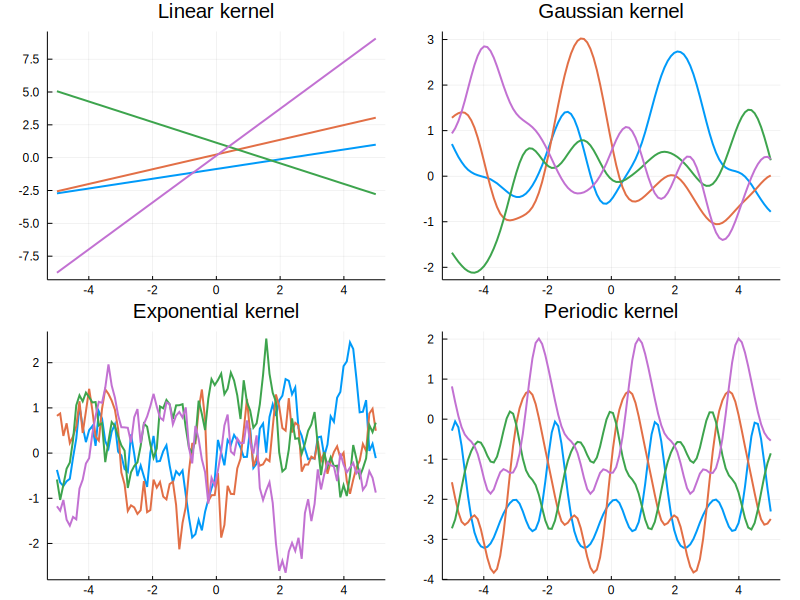

In [8]:
xs = collect(range(-5, stop = 5, length = 100))

plts = []

gp = GaussianProcess(LinearKernel())
push!(plts,
    Plots.plot(xs, rand(gp, xs, 4), 
        label = "",
        linewidth = 2,
        title = "Linear kernel"))

gp = GaussianProcess(GaussianKernel(1, 1))
push!(plts,
    Plots.plot(xs, rand(gp, xs, 4), 
        label = "",
        linewidth = 2,
        title = "Gaussian kernel"))

gp = GaussianProcess(ExponentialKernel(1))
push!(plts,
    Plots.plot(xs, rand(gp, xs, 4), 
        label = "",
        linewidth = 2,
        title = "Exponential kernel"))

gp = GaussianProcess(PeriodicKernel(1.0, 0.5))
push!(plts,
    Plots.plot(xs, rand(gp, xs, 4), 
        label = "",
        linewidth = 2,
        title = "Periodic kernel"))

Plots.plot(plts..., layout = (2, 2), size = [800, 600])